In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.special import lambertw
import matplotlib.animation as animation
from scipy.optimize import fsolve
from scipy.sparse.linalg import cg, gmres

In [ ]:
# Model:

# The model's geometry is expressed in a list containing its nodes. The nodes are described by their coordinates, so we will identify the nodes by its index in this array, and we will bw able to access its coordinates with that index:
nodes = np.array([[0,0],
                  [1,0],
                  [1,1],
                  [0,1]])

# The elements are conformed as per the node's connectivity. We will fins the elements listed in an array, and we will be able to access them by their index. Every item in tis array will contain the nodes in every element:
elements = np.array([[1, 2, 4],
                     [2, 3, 4]])

for i, element in enumerate(elements):
    # Correct indexing for Python (0-based)
    element = element - 1
    elements[i] = element

In [ ]:
# Material properties

E = 26e9        # Young's modulus (Pa)
nu = 0.2        # Poisson's ratio
sigma_y = 2e6   # Tensile strenght (Pa)
G_f = 740       # Fracture energy (N/m)

In [ ]:
# Boundary conditions:

# Let's create variables for the traction to easily modify them:
surface_traction = 3e6  # Presure in N/m^2

# Now, we establish the boundary conditions: [segment coordinates [init, end], type, value (scalar (value) or vector (x,y))]
# BC type legend:
#   U = displacements (m)
#   f = distributed force (Pa)

boundary_conditions = [[[[0,0],[0,1]],'U',0,"free"], [[[0,0],[1,0]],'U',"free",0], [[[1,0], [1,1]],'U', 1e-3, "free"]]#, [[[0,0],[1,0]],'U',"free",0], [[[0,1],[1,1]],'U',"free",0], ] #[[[1,0],[1,1]],'f',surface_traction,0]
    # Note: for displacements we can use "free"

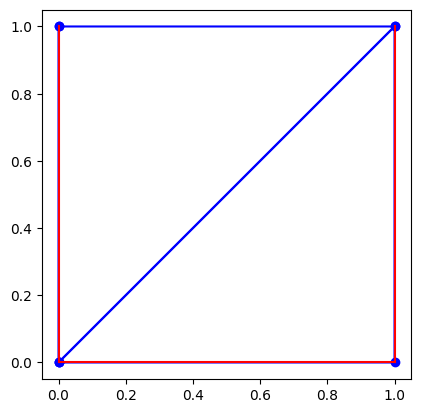

In [ ]:
# Plot the mesh

def plot_mesh(nodes, elements, boundary_conditions):
    for element in elements:
        polygon = [nodes[node - 1] for node in element]
        polygon.append(polygon[0])  # Close the loop
        plt.plot(*zip(*polygon), marker='o', color='blue')

    for segment, bc_type, _, _ in boundary_conditions:
        plt.plot(*zip(*segment), color='red' if bc_type == 'U' else 'green')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_mesh(nodes, elements, boundary_conditions)

In [ ]:
# FEM:

# Then, we will create a function to compute the area (to know the area of the element, det(J) = 2A). For a given "element" (listed in the array "elements") we will compute their area by accessing to their nodal coordinates, listed in the array "nodes":
def area(element):
    """Compute the area of an element"""
    x1, y1 = nodes[element[0]]
    x2, y2 = nodes[element[1]]
    x3, y3 = nodes[element[2]]
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2)

# The following function will help with automatizing the computation of the shape functions. This simply changes the position of the "nodes" in an "element":
def cyclic_permutation(element):
    """Perform cyclic permutation of an element's nodes"""
    return np.array([element[1], element[2], element[0]])


def N(element, x, y):
    """Compute the [N] matrix"""
    N = np.zeros([2, 2*len(element)])

    for permutation in range(len(element)): # For every permutation we compute the shape functions corresponding to one node (indices [0, 1, 2] become [1, 2, 0] in the permuted "element" array):
        x1, y1 = nodes[element[0]]
        x2, y2 = nodes[element[1]]
        x3, y3 = nodes[element[2]]
        ai = x2 * y3 - x3 * y2
        bi = y2 - y3
        ci = x3 - x2
        shape_function = (ai + bi * x + ci * y)
        N[0][2*permutation] = shape_function
        N[1][2*permutation+1] = shape_function

        element = cyclic_permutation(element)

    return N / 2 * area(element)


def B(element): # The [B] matrix for a CST element is constant, therefore it is independent from x or y.
    """Compute the [B] matrix of an element"""
    B = np.zeros([3, 2 * len(element)])

    for permutation in range(len(element)):
        x1, y1 = nodes[element[0]]
        x2, y2 = nodes[element[1]]
        x3, y3 = nodes[element[2]]

        B[0, 2*permutation] = y2 - y3
        B[1, 2*permutation+1] = x3 - x2
        B[2, 2*permutation] = x3 - x2
        B[2, 2*permutation+1] = y2 - y3

        element = cyclic_permutation(element)

    return B / (2 * area(element))


# Define a function to compute the material constitutive matrix. This will deppend on the type of problem treated; in this case, plane strain for an isotropic material is assumed:
def C(E, nu):
    """Compute the material constitutive law matrix"""
    C = np.array([[1-nu, nu,   0         ],
                  [nu,   1-nu, 0         ],
                  [0,    0,    (1-2*nu)/2]]) # CHECK: / 2 correction for Voight notation strain tensor.

    return C * E/((1+nu)*(1-2*nu))


# Functions to check boundary conditions and applied surface tractions:
# We define a function that checks if a given node is in a certain segment:
def node_in_segment(node, segment):
    """Check if a node is in a segment"""
    v1 = nodes[int(node)] - np.array(segment[1])
    v2 = np.array(segment[0]) - np.array(segment[1])

    if np.cross(v1,v2) == 0 and \
       (min(segment[0][0],segment[1][0]) <= nodes[node][0] <= max(segment[0][0],segment[1][0])) and \
       (min(segment[0][1],segment[1][1]) <= nodes[node][1] <= max(segment[0][1],segment[1][1])):
        return True
    else:
        return False


# Assembly of the global stiffness matrix and force vector:
def assembly(elements):
    """Assemble the global stiffness matrix and force vector"""
    # Global stiffness matrix initialization
    n_dofs = 2 * len(nodes)
    K = np.zeros([n_dofs, n_dofs])

    # Global force vector initialization:
    F = np.zeros(n_dofs)

    # Vectorized assembly
    element_dofs = []
    values = []

    C_mat = C(E, nu)

    for element in elements:
        # Compute local stiffness matrix. This is int_{\Omega} [B]^T [C] [B] d\Omega.
        B_mat = B(element)
        K_e = area(element) * (B_mat.T @ C_mat @ B_mat) # Numerical integration is performed by multiplying by the area, as both [B] and [C] are independent from x and y

        # Get global DOF indices for the current element
        global_dofs = np.array([2 * node + i for node in element for i in range(2)]) # For every element, this creates a list of the position in the global stiffness matrix of the dofs "i" of every "node"

        # Record contributions to the global matrix
        K[np.ix_(global_dofs, global_dofs)] += K_e

        # Global force vector assembly:
        # Loop over edges of the element
        for i in range(len(element)):
            # Current edge nodes
            n1, n2 = element[i], element[(i + 1) % len(element)]
            # Check if edge matches a boundary condition
            for condition in boundary_conditions:
                segment, bc_type, tx, ty = condition
                if bc_type == 'f' and node_in_segment(n1, segment) and node_in_segment(n2, segment):
                    # Compute edge length
                    edge_length = np.linalg.norm(nodes[n2] - nodes[n1])
                    # Traction vector
                    traction = np.array([tx, ty])
                    # Local force contributions (constant distribution)
                    f_local = (edge_length / 2) * np.array([*traction, *traction])

                    # Add contributions to the global force vector
                    global_dofs = [2 * n1, 2 * n1 + 1, 2 * n2, 2 * n2 + 1]
                    for dof, f in zip(global_dofs, f_local):
                        F[dof] += f
        u = np.zeros(2 * len(nodes))
        for condition in boundary_conditions:
            segment, bc_type, ux, uy = condition
            if bc_type == 'U':
                for n in range(len(nodes)):
                    if node_in_segment(n, segment):
                        if ux != "free": u[2 * n] = ux
                        if uy != "free": u[2 * n + 1] = uy

    return K, F, u

In [ ]:
# Solve for displacements
def linear_solver(elements, nodes, K, F, u):
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    K_mat = K.copy()
    F_vec = F.copy()
    u_vec = u.copy()

    print('')
    print(f'DOFS: {total_dofs}')
    print(f'DOFS with prescribed displacement: {imposed_displacement_dofs}')
    print(f'DOFS with prescribed force: {displacement_free_dofs}')
    print('')

    K_uu = K_mat[np.ix_(displacement_free_dofs, displacement_free_dofs)]
    K_up = K_mat[np.ix_(displacement_free_dofs, imposed_displacement_dofs)]
    K_pu = K_mat[np.ix_(imposed_displacement_dofs, displacement_free_dofs)]
    K_pp = K_mat[np.ix_(imposed_displacement_dofs, imposed_displacement_dofs)]

    #u[displacement_free_dofs] = (np.linalg.inv(K_uu) @ (F[displacement_free_dofs].reshape(-1, 1) - K_up @ u[imposed_displacement_dofs].reshape(-1, 1))).reshape(-1)
    u_vec[displacement_free_dofs] = spsolve(csc_matrix(K_uu), F_vec[displacement_free_dofs] - K_up @ u_vec[imposed_displacement_dofs])
    F_vec[imposed_displacement_dofs] = K_pu @ u_vec[displacement_free_dofs] + K_pp @ u_vec[imposed_displacement_dofs]
    return K_mat, F_vec, u_vec

def split_problem():
    total_dofs = [2 * node + i for node in range(len(nodes)) for i in range(2)]

    imposed_displacement_dofs = []
    for condition in boundary_conditions:
        segment, bc_type, ux, uy = condition
        if bc_type == 'U':
            for n in range(len(nodes)):
                if node_in_segment(n, segment):
                    if ux != "free": imposed_displacement_dofs.append(2 * n)
                    if uy != "free": imposed_displacement_dofs.append(2 * n + 1)

    displacement_free_dofs = [i for i in total_dofs if i not in imposed_displacement_dofs]

    return total_dofs, imposed_displacement_dofs, displacement_free_dofs

In [ ]:
K, F_prescribed, u_prescribed = assembly(elements)
K, F, u = linear_solver(elements, nodes, K, F_prescribed, u_prescribed)

print(f'K = {K}')
print('')
print(f'F = {F}')
print('')
print(f'U = {u}')


DOFS: [0, 1, 2, 3, 4, 5, 6, 7]
DOFS with prescribed displacement: [0, 6, 1, 3, 2, 4]
DOFS with prescribed force: [5, 7]

K = [[ 1.98611111e+10  9.02777778e+09 -1.44444444e+10 -5.41666667e+09
   0.00000000e+00  0.00000000e+00 -5.41666667e+09 -3.61111111e+09]
 [ 9.02777778e+09  1.98611111e+10 -3.61111111e+09 -5.41666667e+09
   0.00000000e+00  0.00000000e+00 -5.41666667e+09 -1.44444444e+10]
 [-1.44444444e+10 -3.61111111e+09  1.98611111e+10  0.00000000e+00
  -5.41666667e+09 -5.41666667e+09  0.00000000e+00  9.02777778e+09]
 [-5.41666667e+09 -5.41666667e+09  0.00000000e+00  1.98611111e+10
  -3.61111111e+09 -1.44444444e+10  9.02777778e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.41666667e+09 -3.61111111e+09
   1.98611111e+10  9.02777778e+09 -1.44444444e+10 -5.41666667e+09]
 [ 0.00000000e+00  0.00000000e+00 -5.41666667e+09 -1.44444444e+10
   9.02777778e+09  1.98611111e+10 -3.61111111e+09 -5.41666667e+09]
 [-5.41666667e+09 -5.41666667e+09  0.00000000e+00  9.02777778e+09
  -1.44444

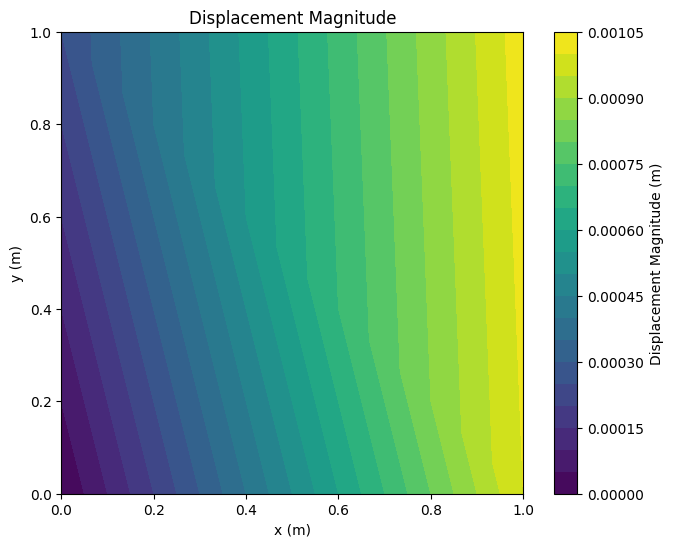

In [ ]:
# Plot the displacements

# Create the triangulation object
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

# Compute magnitude of displacements for visualization
u_x = u[0::2]  # x-displacement (even indices)
u_y = u[1::2]  # y-displacement (odd indices)
u_magnitude = np.sqrt(u_x**2 + u_y**2)

# Plot the displacement magnitude
plt.figure(figsize=(8, 6))
plt.tricontourf(triangulation, u_magnitude, levels=20, cmap='viridis')
plt.colorbar(label='Displacement Magnitude (m)')
plt.title('Displacement Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Compute strains and stress fields

def compute_strains(elements, u):
    epsilon = np.zeros([len(elements), 3])
    for i, element in enumerate(elements):
        u_e = np.array([u[2 * node + j] for node in element for j in range(2)])
        epsilon[i] = B(element) @ u_e
    return epsilon

def compute_stress(elements, u):
    epsilon = compute_strains(elements, u)
    sigma = np.zeros([len(elements), 3])
    for i in range(len(epsilon)):
        sigma[i] = C(E, nu) @ epsilon[i]
    return sigma

In [ ]:
stress = compute_stress(elements, u)
print(stress)
print(np.max(stress) / sigma_y)

[[2.70833333e+07 4.63267086e-10 0.00000000e+00]
 [2.70833333e+07 4.63267086e-10 0.00000000e+00]]
13.541666666666668


In [ ]:
# E-FEM considering strong discontinuities

"""
Linear system of equations:
[K_bb  K_bw  K_bs       ]   {\delta d              }   {- A{f_int^e - f_ext^e}}
[K_wb  K_ww  K_ws       ] · {\delta [|\varepsilon|]} = {- h_[|\varepsilon|]   }
[K_s*b K_s*w K_s*s + K_q]   {\delta [u]            }   {- \Phi_0              }

Simplification to account only for strong discontinuities:
[K_bb  K_bs       ]   {\delta d              }   {- A{f_int^e - f_ext^e}}
[K_s*b K_s*s + K_q]   {\delta [u]            } = {- \Phi_0              }

-\Phi_0 = 0 => K_s*b · \delta d + (K_s*s + K_q) · \delta [u] = 0 => \delta [u] = (K_s*s + K_q)^(-1) · K_s*b · \delta d

So the entire system can be reduced to:
K_sc · \delta d = - A{f_int^e - f_ext^e}
Where:
K_sc = (K_bb - K_bs · (K_s*s + K_q)^(-1) · K_s*b)

Localization criteria: In this first iteration, the crack is predefined, so we know beforehand its location and normal vector
"""

crack_opening = 0.5 # x coordinate of the crack opening
n = np.array([1, 0]) # Normal vector of the crack opening

def heaviside(x, y=None, x0=None, y0=None, n=None):
    """Compute the heaviside function"""
    if y is None and x0 is None and y0 is None and n is None:
        if x < crack_opening: return 0
        else: return 1
    else:
        nx, ny = n
        f = nx * (x - x0) + ny * (y - y0)
        if f < 0: return 0
        else: return 1

def G_s(element, n, criterion='geometric'):
    """Compute the G_s matrix"""
    x1, y1 = nodes[element[0]]
    x2, y2 = nodes[element[1]]
    x3, y3 = nodes[element[2]]
    x0 = (x1 + x2 + x3) / 3
    y0 = (y1 + y2 + y3) / 3

    if criterion == 'geometric':
        b1, b2, b3 = (y2 - y3) * heaviside(x1), (y3 - y1) * heaviside(x2), (y1 - y2) * heaviside(x3)
        c1, c2, c3 = (x3 - x2) * heaviside(x1), (x1 - x3) * heaviside(x2), (x2 - x1) * heaviside(x3)
    else:
        b1, b2, b3 = (y2 - y3) * heaviside(x1, y1, x0, y0, n), (y3 - y1) * heaviside(x2, y2, x0, y0, n), (y1 - y2) * heaviside(x3, y3, x0, y0, n)
        c1, c2, c3 = (x3 - x2) * heaviside(x1, y1, x0, y0, n), (x1 - x3) * heaviside(x2, y2, x0, y0, n), (x2 - x1) * heaviside(x3, y3, x0, y0, n)

    dphi_dx = (b1 + b2 + b3) / (2 * area(element))
    dphi_dy = (c1 + c2 + c3) / (2 * area(element))
    # Compute \nabla \phi:
    G_s = np.zeros((len(element), 2))
    G_s[0, 0] = dphi_dx
    G_s[1, 1] = dphi_dy
    G_s[2, 0] = dphi_dy
    G_s[2, 1] = dphi_dx
    return - G_s

def H_s(n):
    """Compute the H_s matrix"""
    nx, ny = n
    H_s = np.zeros((len(element), 2))
    H_s[0, 0] = nx
    H_s[1, 1] = ny
    H_s[2, 0] = ny
    H_s[2, 1] = nx
    return H_s

def K_bb(element):
    """Compute the stiffness matrix K_bb"""
    B_mat = B(element)
    C_mat = C(E, nu)
    return area(element) * (B_mat.T @ C_mat @ B_mat)

def K_bs(element, n, criterion='geometric'):
    """Compute the stiffness matrix K_bs"""
    n_e = n.copy()
    B_mat = B(element)
    C_mat = C(E, nu)
    G_s_mat = G_s(element, n, criterion)
    return area(element) * B_mat.T @ C_mat @ G_s_mat @ n_e.reshape(-1, 1)

def K_sb(element, n):
    """Compute the stiffness matrix K_sb"""
    n_e = n.copy()
    H_s_mat = H_s(n)
    C_mat = C(E, nu)
    B_mat = B(element)
    return n_e.reshape(1, -1) @ H_s_mat.T @ C_mat @ B_mat

def K_ss(element, n, criterion='geometric'):
    """Compute the stiffness matrix K_ss"""
    n_e = n.copy()
    H_s_mat = H_s(n)
    C_mat = C(E, nu)
    G_s_mat = G_s(element, n, criterion)
    return n_e.reshape(1, -1) @ H_s_mat.T @ C_mat @ G_s_mat @ n_e.reshape(-1, 1)

def K_sc(sigma_y, G_f, element, n, u_modulus, criterion='geometric'):
    """Compute the stiffness matrix K_sc"""
    K_bb_mat = K_bb(element)
    K_bs_mat = K_bs(element, n, criterion)
    K_sb_mat = K_sb(element, n)
    K_ss_mat = K_ss(element, n, criterion)
    K_q_mat = K_q(sigma_y, G_f, u_modulus)
    return K_bb_mat - (K_bs_mat @ K_sb_mat) / (K_ss_mat + K_q_mat)

def K_q(sigma_y, G_f, u_modulus):
    """Compute the stiffness matrix K_q"""
    return (sigma_y**2 / G_f) * np.exp(- (sigma_y / G_f) * u_modulus)

def u_discontinuity(sigma_y, G_f, element, n, d):
    """Compute the magnitude of the crack displacement"""
    T_e = K_sb(element, n) @ d
    M = K_ss(element, n)
    u_disc = (G_f / sigma_y) * (lambertw(sigma_y**2 * np.exp(sigma_y * T_e / (G_f * M)) / (G_f * M)) - sigma_y * T_e / (G_f * M))
    return u_disc.real

# Localization and opening criteria:
"""
With this first (purely geometric) approach, we will project the traction vector in the normal direction to the crack opening (predefined).
Localization will take place when this component of the traction vector reaches a treshold (sigma_y)
"""
def sigma_projection(sigma, n):
    """Project the sigma vector in the normal direction"""
    nx, ny = n
    sigma_xx, sigma_yy, sigma_xy = sigma
    return sigma_xx * nx**2 + sigma_yy * ny**2 + 2 * sigma_xy * nx * ny

In [ ]:
print('[B]')
print(B(elements[0]))
print('')
print('[G_s]')
print(G_s(elements[0], n))
print('')
print('[H_s^*]')
print(H_s(n))

[B]
[[-1.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.]
 [-1. -1.  0.  1.  1.  0.]]

[G_s]
[[-1. -0.]
 [-0. -0.]
 [-0. -1.]]

[H_s^*]
[[1. 0.]
 [0. 0.]
 [0. 1.]]


In [ ]:
# Check that all extra matrices dimensions are correct
print('Element [0]:')
print('K_bb:')
print(K_bb(elements[0]))
print('')
print('K_bs:')
print(K_bs(elements[0], n))
print('')
print('K_sb:')
print(K_sb(elements[0], n))
print('')
print('K_ss:')
print(K_ss(elements[0], n))
print('')
print('K_bs @ K_sb:')
print(K_bs(elements[0], n) @ K_sb(elements[0], n))
print('')
print('K_sc:')
print(K_sc(sigma_y, G_f, elements[0], n, 0))
print('')
K_bs_mat = K_bs(elements[0], n)
K_sb_mat = K_sb(elements[0], n)
K_ss_mat = K_ss(elements[0], n)
K_q_mat = K_q(sigma_y, G_f, 1e-5)
print((K_bs_mat @ K_sb_mat) / (K_ss_mat + K_q_mat))

Element [0]:
K_bb:
[[ 1.98611111e+10  9.02777778e+09 -1.44444444e+10 -5.41666667e+09
  -5.41666667e+09 -3.61111111e+09]
 [ 9.02777778e+09  1.98611111e+10 -3.61111111e+09 -5.41666667e+09
  -5.41666667e+09 -1.44444444e+10]
 [-1.44444444e+10 -3.61111111e+09  1.44444444e+10  0.00000000e+00
   0.00000000e+00  3.61111111e+09]
 [-5.41666667e+09 -5.41666667e+09  0.00000000e+00  5.41666667e+09
   5.41666667e+09  0.00000000e+00]
 [-5.41666667e+09 -5.41666667e+09  0.00000000e+00  5.41666667e+09
   5.41666667e+09  0.00000000e+00]
 [-3.61111111e+09 -1.44444444e+10  3.61111111e+09  0.00000000e+00
   0.00000000e+00  1.44444444e+10]]

K_bs:
[[ 1.44444444e+10]
 [ 3.61111111e+09]
 [-1.44444444e+10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.61111111e+09]]

K_sb:
[[-2.88888889e+10 -7.22222222e+09  2.88888889e+10  0.00000000e+00
   0.00000000e+00  7.22222222e+09]]

K_ss:
[[-2.88888889e+10]]

K_bs @ K_sb:
[[-4.17283951e+20 -1.04320988e+20  4.17283951e+20  0.00000000e+00
   0.00000000e+00  1.04320988e+20]
 

In [ ]:
# SANDBOX: Enhanced strain

# Iterative solver

def iterative_solver(E, nu, sigma_y, G_f, elements, nodes, solver='gmres', criterion='geometric'):
    """
    Perform the non-linear analysis using the IMPLICIT iterative solver.
    """
    # Initialize variables
    K, F_prescribed, d_prescribed = assembly(elements)
    print('Assembled F:')
    print(F_prescribed)
    print('Assembled u:')
    print(d_prescribed)
    F, d = np.zeros_like(F_prescribed), np.zeros_like(d_prescribed)

    # Define the initial conditions and store them in the states vectors:
    stiffness_states = [K.copy()]
    force_states = [F.copy()]
    displacement_states = [d.copy()]
    strain_states = [np.zeros((len(elements), 3))]
    stress_states = [np.zeros((len(elements), 3))]

    # Store the normal vectors for each element (useful for stress localization criteria):
    if criterion=='geometric': n_vectors = [n for _ in range(len(elements))]
    else: n_vectors = {}

    # Create a variable to store the crack opening (i.e.: |\Tilde{u}|) for each element:
    tilde_u = np.zeros(len(elements))
    tilde_u_states = [tilde_u.copy()]

    # Constants for stability:
    TOLERANCE = 1e-6
    MAX_ITER = 100
    a_ref = sigma_y / E

    iteration = 0

    # Set the load control variable:
    control_variable, max_load, incremental_variable, dofs_to_check = define_control_variable(boundary_conditions, F_prescribed, d_prescribed)

    while np.linalg.norm(incremental_variable[dofs_to_check]) < np.linalg.norm(max_load[dofs_to_check]):
        if iteration == 0:
            K, F, d, load_factor = initial_iteration(elements, nodes, sigma_y, K, F_prescribed, d_prescribed)
            if load_factor is None: return K, F, d, None, compute_strains(elements, d), compute_stress(elements, d)
            delta_t = 0.1 * load_factor
            R = compute_residual(control_variable, K, F, d, delta_t)

        else:
            if solver == 'gmres':
                K, F, d, tilde_u, n_vectors, delta_t = gmres_solver(elements, TOLERANCE, MAX_ITER, sigma_y, G_f, F_prescribed, d_prescribed, force_states, displacement_states, tilde_u_states, n_vectors, delta_t, criterion)
            elif solver == 'impl-ex':
                delta_t_next = compute_delta_t(delta_t, R, TOLERANCE, a_ref, stress_states)
                K, F, d, tilde_u, n_vectors, R, delta_t_next = IMPL_EX_solver(elements, control_variable, TOLERANCE, MAX_ITER, sigma_y, G_f, F_prescribed, d_prescribed, stiffness_states, force_states, displacement_states, tilde_u_states, n_vectors, delta_t, delta_t_next, criterion)
            else:
                print('Invalid solver')
                return K, F, d, None, compute_strains(elements, d), compute_stress(elements, d)

        stiffness_states.append(K.copy())
        force_states.append(F.copy())
        displacement_states.append(d.copy())
        tilde_u_states.append(tilde_u.copy())
        strain_states.append(compute_strains(elements, d, tilde_u))
        stress_states.append(compute_stress(elements, d, tilde_u))

        iteration += 1
        if control_variable == 'F': incremental_variable = F
        else: incremental_variable = d

        print(f'Iteration {iteration}: Load factor {np.linalg.norm(incremental_variable) / np.linalg.norm(max_load)}')

    return stiffness_states, force_states, displacement_states, tilde_u_states, strain_states, stress_states


def define_control_variable(boundary_conditions, F, d):
    """Return the control variable"""
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()
    for condition in boundary_conditions:
        segment, bc_type, ux, uy = condition
        if bc_type == 'F':
            return bc_type, F.copy(), np.zeros(len(F)), displacement_free_dofs
    return bc_type, d.copy(), np.zeros(len(d)), imposed_displacement_dofs

def compute_residual(control_variable, K, F, d, delta_t):
    """Compute the residual vector"""
    if control_variable == 'F':
        F_increment = F * (1 + delta_t)
        return F_increment - K @ d
    else:
        d_increment = d * (1 + delta_t)
        return F - K @ d_increment

def initial_iteration(elements, nodes, sigma_y, K, F_prescribed, u_prescribed, criterion='geometric'):
    """Handle the elastic solution with simplified logic"""
    # Solve initial system
    F_imp = F_prescribed.copy()
    u_imp = u_prescribed.copy()
    K, F, d = linear_solver(elements, nodes, K, F_imp, u_imp)
    epsilon = compute_strains(elements, d)
    sigma = compute_stress(elements, d)

    # Check if cracking occurs
    if criterion == 'geometric':
        sigma_projected = np.array([sigma_projection(s, n) for s in sigma])
        cracks = sigma_projected >= sigma_y
    else:
        eigenvalues_sigma = np.array([eigen_sigma(E, nu, e)[0] for e in epsilon])
        cracks = eigenvalues_sigma >= sigma_y
    if cracks.any():
        # Compute the elastic solution:
        if criterion == 'geometric': elastic_load_factor = sigma_y / np.max(sigma_projected)
        else: elastic_load_factor = sigma_y / np.max(eigenvalues_sigma)
        F_imp *= elastic_load_factor
        u_imp *= elastic_load_factor
        K, F, d = linear_solver(elements, nodes, K, F_imp, u_imp)
        return K, F, d, elastic_load_factor
    else:
        return K, F, d, None


def compute_delta_t(delta_t, R, tolerance, a_ref, stress_states):
    """Compute the next load increment"""
    try:
        delta_displacements = displacement_states[-1] - displacement_states[-2]
        delta_displacements_prev = displacement_states[-2] - displacement_states[-3]
        return delta_t * np.sqrt((tolerance * a_ref) / max(max(abs(delta_displacements - delta_displacements_prev)), tolerance * a_ref))

    except:
        return delta_t * np.sqrt((tolerance * a_ref) / max(np.linalg.norm(R), tolerance * a_ref))

def compute_q(sigma_y, G_f, u_modulus):
    """Comute the hardening function"""
    return sigma_y * (1 - np.exp(- (sigma_y / G_f) * u_modulus))

def compute_element_strain(element, d):
    return B(element) @ d

def compute_strains(elements, u, tilde_u=None):
    epsilon = np.zeros([len(elements), 3])
    for e, element in enumerate(elements):
        u_e = np.array([u[2 * node + j] for node in element for j in range(2)])
        if tilde_u is None: epsilon[e] = B(element) @ u_e
        else: epsilon[e] = B(element) @ u_e + tilde_u[e] * G_s(element, n) @ n
    return epsilon

def compute_stress(elements, u, tilde_u=None):
    epsilon = compute_strains(elements, u, tilde_u)
    sigma = np.zeros([len(elements), 3])
    for i in range(len(epsilon)):
        sigma[i] = C(E, nu) @ epsilon[i]
    return sigma


def IMPL_EX_solver(elements, ctrl_var, tol, max_iter, sigma_y, G_f, F_prescribed, d_prescribed, K_states, F_states, d_states, tilde_u_states, n_vectors, dt, dt_next, criterion='geometric'):
    """Perform the non-linear analysis using the IMPL-EX solver"""
    print('')
    print('')
    print('Now solving IMPL-EX solver')
    local_iter = 0
    # Split the problem in unknoun and impossed variables:
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    # print(f'S_states[-1]: {S_states[-1]}')
    K, F, d, tilde_u = K_states[-1].copy(), F_states[-1].copy(), d_states[-1].copy(), tilde_u_states[-1].copy()
    delta_F, delta_d = F_states[-1].copy() - F_states[-2].copy(), d_states[-1].copy() - d_states[-2].copy()

    # Apply the load increment:
    imposed_force = F + dt_next * F_prescribed
    imposed_force[imposed_displacement_dofs] = 0
    imposed_displacement = d + dt_next * d_prescribed
    imposed_displacement[displacement_free_dofs] = 0

    print('Imposed force vector:')
    print(imposed_force)
    print('Imposed displacement vector:')
    print(imposed_displacement)
    print('')

    # We give an initial arbitrary value for the residual:
    R = compute_residual(ctrl_var, K, F, d, dt_next)
    print(f'Initial residual is: {np.linalg.norm(R)}')

    while np.linalg.norm(R) > tol:
        # Explicitly extrapolate the displacement increment:
        tilde_d = d + (dt_next / dt) * delta_d
        # Correct known displacements:
        #tilde_d[imposed_displacement_dofs] = imposed_displacement[imposed_displacement_dofs]
        print(f'delta_t:  {dt_next}, dt_next / dt: {dt_next / dt}')
        print('last displacement (d):')
        print(d)
        print('')
        print('displacement increment (delta_d):')
        print(delta_d)
        print('')
        print('explicit extrapolation (tilde_d):')
        print(tilde_d)
        print('')

        # Reinitialize the stiffness matrix:
        n_dofs = 2 * len(nodes)
        K = np.zeros([n_dofs, n_dofs])

        for e, element in enumerate(elements):
            global_dofs = np.array([2 * node + i for node in element for i in range(2)])

            tilde_u_modulus = np.linalg.norm(u_discontinuity(sigma_y, G_f, element, n_vectors[e], tilde_d[global_dofs])) # We see that tilde_u_vector has actually just 1 componen but it is an nd.array(1,1)
            print(f'|tilde_u| = {tilde_u_modulus}')
            tilde_u[e] = tilde_u_modulus

            if criterion != 'geometric':
                eigenvalue, eigenvector = eigen_sigma(E, nu, compute_element_strain(element, d))
                if eigenvalue >= sigma_y:
                    n_vectors.setdefault(e, eigenvector)  # Add eigenvector if not already present

            # Compute local stiffness matrix:
            K_e = K_sc(sigma_y, G_f, element, n_vectors[e], tilde_u_modulus) # Numerical integration is performed within this function already
            # Record contributions to the global matrix
            K[np.ix_(global_dofs, global_dofs)] += K_e

        if ctrl_var == 'F':
            pass
        else:
            # Compute tilde_F:
            tilde_F = np.zeros(n_dofs)

            K_pu = K[np.ix_(imposed_displacement_dofs, displacement_free_dofs)]
            K_pp = K[np.ix_(imposed_displacement_dofs, imposed_displacement_dofs)]

            tilde_F[displacement_free_dofs] = imposed_force[displacement_free_dofs]
            tilde_F[imposed_displacement_dofs] = K_pu @ tilde_d[displacement_free_dofs] + K_pp @ tilde_d[imposed_displacement_dofs]

            # We compute the error as te difference between the known components of u:
            if ctrl_var == 'F':
                # Ok, in this scenario we don't mind having to invert the stiffness matrix, because only if the structure offers some resistance, we'll be able to compute the solution
                # R = (np.linalg.norm(imposed_force[displacement_free_dofs]) - np.linalg.norm(tilde_F[displacement_free_dofs])) / np.linalg.norm(tilde_F[displacement_free_dofs])
                R = (imposed_force - F) - K @ (tilde_d - d)
                delta_d = np.linalg.inv(K) @ R
            else:
                R = (np.linalg.norm(imposed_displacement[imposed_displacement_dofs]) - np.linalg.norm(tilde_d[imposed_displacement_dofs])) / np.linalg.norm(tilde_d[imposed_displacement_dofs])
                delta_d = (dt / dt_next) * R * d + (1 + R) * delta_d

            print('R:')
            print(f'New residual: {R}')
            print(f'Tolerance: {tol}, R < tolerance? {np.linalg.norm(R) < tol}')
            print('New delta_d:')
            print(delta_d)
        local_iter += 1
        print(f'Local iteration: {local_iter}')
        print('')
        print('')
        """
        This might be added in case of facing issues with the time increment:

        if local_iter == max_iter:# or abs(np.max(np.array([sigma_projection(s, n) for s in stress])) - np.max(np.array([sigma_projection(s, n) for s in stress_states[-1]]))) > 0.1 * sigma_y:
            # Make the step half the size of the previous one
            dt_next *= 0.5

            # delta_t_next *= np.linalg.norm(stress_states[-1] - stress) / E

            # Restore the last stiffness and displacement saved in K_states and d_states
            K, F, d, tilde_u = K_states[-1].copy(), F_states[-1].copy(), d_states[-1].copy(), tilde_u_states[-1].copy()
            delta_F, delta_d = F_states[-1].copy() - F_states[-2].copy(), d_states[-1].copy() - d_states[-2].copy()
            strain, stress = E_states[-1].copy(), S_states[-1].copy()

            # Apply the load increment:
            imposed_force = F + dt_next * F_prescribed
            imposed_displacement = d + dt_next * d_prescribed

            # We give an initial arbitrary value for the residual:
            R = compute_residual(ctrl_var, K, F, d, dt_next)
            local_iter = 0
        """
    return K.copy(), tilde_F, tilde_d, tilde_u, n_vectors, R, dt_next


def gmres_solver(elements, tol, max_iter, sigma_y, G_f, F_prescribed, d_prescribed, F_states, d_states, tilde_u_states, n_vectors, dt_next, criterion='geometric'):
    """Perform the non-linear analysis using the implicit solver"""
    local_iter = 0
    # Split the problem in unknoun and impossed variables:
    total_dofs, imposed_displacement_dofs, displacement_free_dofs = split_problem()

    # Initialize the variables
    F, d, tilde_u = F_states[-1].copy(), d_states[-1].copy(), tilde_u_states[-1].copy()
    tilde_u_next = tilde_u.copy()

    local_iter = 0
    R = 2 * tol

    while R > tol:
        delta_d, delta_F = d_prescribed * dt_next, F_prescribed * dt_next
        K_mat = np.zeros([len(total_dofs), len(total_dofs)])

        for e, element in enumerate(elements):
            if criterion != 'geometric':
                eigenvalue, eigenvector = eigen_sigma(E, nu, compute_element_strain(element, d))
                if eigenvalue >= sigma_y:
                    n_vectors.setdefault(e, eigenvector)  # Add eigenvector if not already present

            global_dofs = np.array([2 * node + i for node in element for i in range(2)])

            # Compute local stiffness matrix:
            K_e = K_sc(sigma_y, G_f, element, n_vectors[e], tilde_u_next[e]) # Numerical integration is performed within this function already
            # Record contributions to the global matrix
            K[np.ix_(global_dofs, global_dofs)] += K_e

        K_uu = K_mat[np.ix_(displacement_free_dofs, displacement_free_dofs)]
        K_up = K_mat[np.ix_(displacement_free_dofs, imposed_displacement_dofs)]
        K_pu = K_mat[np.ix_(imposed_displacement_dofs, displacement_free_dofs)]
        K_pp = K_mat[np.ix_(imposed_displacement_dofs, imposed_displacement_dofs)]

        d_p = delta_d[np.ix_(imposed_displacement_dofs)]
        F_p = delta_F[np.ix_(displacement_free_dofs)]

        d_u = gmres(csc_matrix(K_uu), F_p - K_up @ d_p)[0]
        F_u = K_pu @ d_u + K_pp @ d_p

        delta_d[np.ix_(displacement_free_dofs)] = d_u
        delta_F[np.ix_(imposed_displacement_dofs)] = F_u

        d_next, F_next = d + delta_d, F + delta_F

        for e, element in enumerate(elements):
            global_dofs = np.array([2 * node + i for node in element for i in range(2)])
            tilde_u_next[e] = np.linalg.norm(u_discontinuity(sigma_y, G_f, element, n_vectors[e], d_next[global_dofs]))

        R = np.max(tilde_u_next - tilde_u)
        tilde_u = tilde_u_next.copy()

        local_iter += 1

        print('')
        print(f'Iteration: {local_iter}')
        print(f'R: {R}')
        print('')
        print('d:')
        print(d)
        print('d_next:')
        print(d_next)
        print('delta_d:')
        print(delta_d)
        print('')
        print('tilde_u:')
        print(tilde_u)
        print('tilde_u_next:')
        print(tilde_u_next)
        print('')

        if local_iter == 100:
            # Make the step half the size of the previous one
            dt_next *= 0.5
            local_iter = 0
            print('load reduced')
            print(f'Error: {R}')

    return K_mat, F_next, d_next, tilde_u_next, n_vectors, dt_next

# We need an easy way to reshape the stress tensor, in Voigt notation, to its matricial form
def eigen_sigma(E, nu, epsilon):
    """Reshape the stress tensor"""
    sigma = np.zeros((3, 3))
    sigma[0, 0] = (1 - nu) * epsilon[0] + nu * epsilon[2]
    sigma[1, 1] = (1 - nu) * epsilon[1] + nu * epsilon[0]
    sigma[2, 2] = nu * (epsilon[0] + epsilon[1])
    sigma[0, 1] = sigma[1, 0] = (1 - 2 * nu) / 2 * epsilon[2]
    sigma *= E / ((1 + nu) * (1 - 2 * nu))

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    # Find the index of the maximum eigenvalue
    max_index = np.argmax(eigenvalues)
    # Return the maximum eigenvalue and its corresponding eigenvector
    """Note: we will be taking the first two coordinates of the eigenvector. As we are dealing with a plane problem we will assume the eigenvalues found for the max stress will be in-plane."""
    return eigenvalues[max_index], eigenvectors[:2, max_index]


stiffness_states, force_states, displacement_states, tilde_u_states, strain_states, stress_states = iterative_solver(E, nu, sigma_y, G_f, elements, nodes, 'impl-ex')
stiffness_states_impl, force_states_impl, displacement_states_impl, tilde_u_states_impl, strain_states_impl, stress_states_impl = iterative_solver(E, nu, sigma_y, G_f, elements, nodes, 'gmres')

Se han truncado las últimas 5000 líneas del flujo de salida.
Iteration 125: Load factor 1.0199928993835683


Now solving IMPL-EX solver
Imposed force vector:
[0. 0. 0. 0. 0. 0. 0. 0.]
Imposed displacement vector:
[0.         0.         0.00099692 0.         0.00099692 0.
 0.         0.        ]

Initial residual is: 4847800.931466061
delta_t:  0.0073846153846153844, dt_next / dt: 1.0
last displacement (d):
[ 0.          0.          0.00098954  0.          0.00098954 -0.00024738
  0.         -0.00024738]

displacement increment (delta_d):
[ 0.00000000e+00  0.00000000e+00  7.38461538e-06  0.00000000e+00
  7.38461538e-06 -1.84615385e-06  0.00000000e+00 -1.84615385e-06]

explicit extrapolation (tilde_d):
[ 0.          0.          0.00099692  0.          0.00099692 -0.00024923
  0.         -0.00024923]

|tilde_u| = 0.0009289935844064141
|tilde_u| = 0.0009289935844064141
R:
New residual: 0.0
Tolerance: 1e-06, R < tolerance? True
New delta_d:
[ 0.00000000e+00  0.00000000e+00  7.38461538e-06  

In [ ]:
print(stiffness_states)
print(f'Force states: {force_states}')
print(f'Displacement states: {displacement_states}')
print(f'Strain states: {strain_states}')
print(f'Stress states: {stress_states}')

[array([[ 1.98611111e+10,  9.02777778e+09, -1.44444444e+10,
        -5.41666667e+09,  0.00000000e+00,  0.00000000e+00,
        -5.41666667e+09, -3.61111111e+09],
       [ 9.02777778e+09,  1.98611111e+10, -3.61111111e+09,
        -5.41666667e+09,  0.00000000e+00,  0.00000000e+00,
        -5.41666667e+09, -1.44444444e+10],
       [-1.44444444e+10, -3.61111111e+09,  1.98611111e+10,
         0.00000000e+00, -5.41666667e+09, -5.41666667e+09,
         0.00000000e+00,  9.02777778e+09],
       [-5.41666667e+09, -5.41666667e+09,  0.00000000e+00,
         1.98611111e+10, -3.61111111e+09, -1.44444444e+10,
         9.02777778e+09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.41666667e+09,
        -3.61111111e+09,  1.98611111e+10,  9.02777778e+09,
        -1.44444444e+10, -5.41666667e+09],
       [ 0.00000000e+00,  0.00000000e+00, -5.41666667e+09,
        -1.44444444e+10,  9.02777778e+09,  1.98611111e+10,
        -3.61111111e+09, -5.41666667e+09],
       [-5.41666667e+09, -5.41666

7.407407407407407e-05


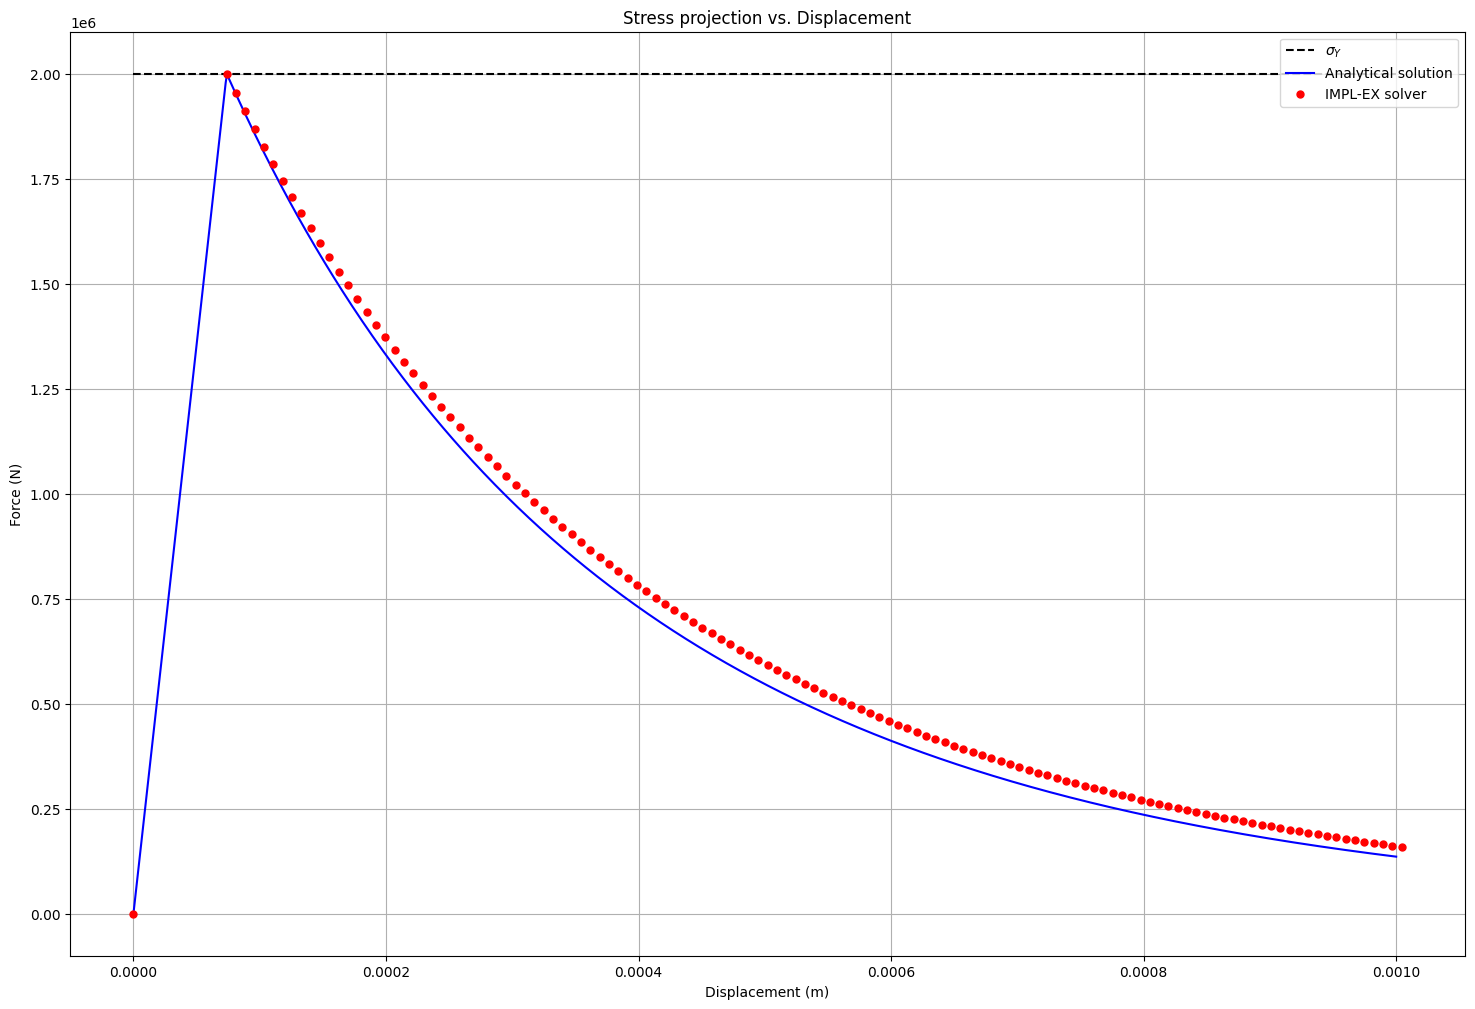

In [ ]:
L_0 = 1 # m
alpha = 0 # rad
n_vector = np.array([1, 0, 0])

# Range of u values
u_values = np.linspace(0, 1e-3, 1000)

# Linear elastic solution:
def linear_elastic(u):
    sigma_xx = u * E / ((1 + nu) * (1 - nu) * L_0)
    return sigma_xx

# Function to solve
def equation(sigma_xx, u):
    term1 = L_0 * ((1 + nu) * (1 - nu)) / E * sigma_xx
    term2 = (G_f / sigma_y) * np.log(sigma_xx / sigma_y) * np.cos(alpha)
    return term1 - term2 - u

# Solve for each u
sigma_xx_solutions = []
for u in u_values:
    sigma_xx = linear_elastic(u)
    if sigma_xx <= sigma_y:
        sigma_xx_solutions.append(sigma_xx)
    else:
        # Initial guess for sigma_xx
        sigma_xx_guess = sigma_xx_solutions[-1]

        # Solve the equation for the current u
        sigma_xx_solution = fsolve(equation, sigma_xx_guess, args=(u,))
        sigma_xx_solutions.append(sigma_xx_solution[0])

# Convert solutions to a numpy array for easier handling
sigma_xx_solutions = np.array(sigma_xx_solutions)
print(u_values[np.argmax(sigma_xx_solutions)])

# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(u_values, sigma_y * np.ones_like(u_values), label=r'$\sigma_{Y}$', color='black', linestyle='--')
plt.plot(u_values, sigma_xx_solutions, label=r'Analytical solution', color='blue')
for i in range(len(force_states)):
  if i == 0:
    plt.plot(displacement_states[i][2], n_vector @ stress_states[i][1] * 1 * 1, 'o', color='red', markersize=5, label='IMPL-EX solver')
    #plt.plot(displacement_states_impl[i][2], n_vector @ stress_states_impl[i][0] * 1 * 1, 'o', color='purple', markersize=5, label='GMRES solver')

  else:
    plt.plot(displacement_states[i][2], n_vector @ stress_states[i][0] * 1 * 1, 'o', color='red', markersize=5)
    #plt.plot(displacement_states_impl[i][2], n_vector @ stress_states_impl[i][0] * 1 * 1, 'o', color='purple', markersize=5)

plt.xlabel('Displacement (m)')
plt.ylabel('Force (N)')
plt.title('Stress projection vs. Displacement')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# Plot the displacements

# IGNORE: This is to run the animation in Google Colab
"""
from IPython.display import HTML


factor_of_deformation = 100

# Function to modify node positions
def modify_nodes(nodes_coordinates, displacement):
    x_coordinates = nodes_coordinates[:, 0] + factor_of_deformation * displacement[0::2]
    y_coordinates = nodes_coordinates[:, 1] + factor_of_deformation * displacement[1::2]
    nodes_modified = np.column_stack((x_coordinates, y_coordinates))
    return nodes_modified

# Create the figure and axis
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, 2)  # Adjust limits as per your mesh
ax.set_ylim(-1, 2)

# List to store all frames
images = []

# Build frames for the animation
for displacement in displacement_states:
    nodes_modified = modify_nodes(nodes, displacement)
    frame_artists = []
    for element in elements:
        polygon = [nodes_modified[node - 1] for node in element]
        polygon.append(polygon[0])  # Close the loop
        line, = ax.plot(*zip(*polygon), marker='o', color='black')  # Get a single Line2D object
        frame_artists.append(line)
    images.append(frame_artists)

# Create the animation
anim = animation.ArtistAnimation(fig, images, interval=100, blit=True, repeat_delay=1000)

#plt.show()

# Show the animation in Jupyter Notebook
plt.close(fig)  # Prevent a static plot from being displayed
HTML(anim.to_jshtml())
"""

"\nfrom IPython.display import HTML\n\n\nfactor_of_deformation = 100\n\n# Function to modify node positions\ndef modify_nodes(nodes_coordinates, displacement):\n    x_coordinates = nodes_coordinates[:, 0] + factor_of_deformation * displacement[0::2]\n    y_coordinates = nodes_coordinates[:, 1] + factor_of_deformation * displacement[1::2]\n    nodes_modified = np.column_stack((x_coordinates, y_coordinates))\n    return nodes_modified\n\n# Create the figure and axis\nfig, ax = plt.subplots()\nax.set_aspect('equal', adjustable='box')\nax.set_xlim(-1, 2)  # Adjust limits as per your mesh\nax.set_ylim(-1, 2)\n\n# List to store all frames\nimages = []\n\n# Build frames for the animation\nfor displacement in displacement_states:\n    nodes_modified = modify_nodes(nodes, displacement)\n    frame_artists = []\n    for element in elements:\n        polygon = [nodes_modified[node - 1] for node in element]\n        polygon.append(polygon[0])  # Close the loop\n        line, = ax.plot(*zip(*polygon